# Table of Contents
 <p>

In [44]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import Lasso, LassoCV, Ridge, RidgeCV
from sklearn.model_selection import cross_val_score

In [72]:
data = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')
y_test = pd.read_csv('./gender_submission.csv')
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [68]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
Survived         891 non-null int64
Age              891 non-null int64
Fare             891 non-null int64
Embarked_C       891 non-null uint8
Embarked_Q       891 non-null uint8
Embarked_S       891 non-null uint8
Person_child     891 non-null uint8
Person_female    891 non-null uint8
Person_male      891 non-null uint8
Family           891 non-null int64
Class_1          891 non-null uint8
Class_2          891 non-null uint8
Class_3          891 non-null uint8
dtypes: int64(4), uint8(9)
memory usage: 35.7 KB


In [73]:
data.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1, inplace=True)
test.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1, inplace=True)

In [74]:
def get_person(x):
    age, sex = x
    return 'child' if age < 16 else sex

In [75]:
data['Person'] = data[['Age', 'Sex']].apply(get_person, axis=1)
test['Person'] = data[['Age', 'Sex']].apply(get_person, axis=1)
data.drop(['Sex'], axis=1, inplace=True)
test.drop(['Sex'], axis=1, inplace=True)
data.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Embarked,Person
0,0,3,22.0,1,0,7.2500,S,male
1,1,1,38.0,1,0,71.2833,C,female
2,1,3,26.0,0,0,7.9250,S,female
3,1,1,35.0,1,0,53.1000,S,female
4,0,3,35.0,0,0,8.0500,S,male


In [76]:
data.Fare = data.Fare.apply(lambda x: int(x))
test.Fare = test.Fare.fillna(test.Fare.mean())
test.Fare = test.Fare.apply(lambda x: int(x))

rand_age1 = np.random.randint(
    int(data.Age.mean() - data.Age.std()),
    int(data.Age.mean() + data.Age.std()),
    size=data.Age.isnull().sum())
data.Age[data.Age.isnull()] = rand_age1
data.Age = data.Age.apply(lambda x: int(x))
rand_age2 = np.random.randint(
    int(data.Age.mean() - data.Age.std()),
    int(data.Age.mean() + data.Age.std()),
    size=test.Age.isnull().sum())
test.Age[test.Age.isnull()] = rand_age2
test.Age = test.Age.apply(lambda x: int(x))

data.Embarked[data.Embarked.isnull() == True] = 'S'
test.Embarked[test.Embarked.isnull() == True] = 'S'

In [77]:
#test
# data.Age.isnull().sum()
data.Age.describe()

count    891.000000
mean      29.226712
std       13.512383
min        0.000000
25%       20.000000
50%       28.000000
75%       36.000000
max       80.000000
Name: Age, dtype: float64

In [88]:
data = pd.get_dummies(data)
test = pd.get_dummies(test)
data.head()

,Survived,Age,Fare,Embarked_C,Embarked_Q,Embarked_S,Person_child,Person_female,Person_male,Family,Class_1,Class_2,Class_3
0,0,22,7,0,0,1,0,0,1,1,0,0,1
1,1,38,71,1,0,0,0,1,0,1,1,0,0
2,1,26,7,0,0,1,0,1,0,0,0,0,1
3,1,35,53,0,0,1,0,1,0,1,1,0,0
4,0,35,8,0,0,1,0,0,1,0,0,0,1


In [81]:
data['Family'] = data['SibSp'] + data['Parch']
data.Family[data.Family > 0] = 1
test['Family'] = test['SibSp'] + test['Parch']
test.Family[test.Family > 0] = 1

data.drop(['SibSp', 'Parch'], axis=1, inplace=True)
test.drop(['SibSp', 'Parch'], axis=1, inplace=True)

In [85]:
class_dummies1 = pd.get_dummies(data.Pclass)
class_dummies1.columns = ['Class_1', 'Class_2', 'Class_3']
class_dummies2 = pd.get_dummies(data.Pclass)
class_dummies2.columns = ['Class_1', 'Class_2', 'Class_3']

data = data.join(class_dummies1)
data.drop(['Pclass'], axis=1, inplace=True)
test = test.join(class_dummies2)
test.drop(['Pclass'], axis=1, inplace=True)

In [105]:
data.head()
test.head()

,Age,Fare,Family,Class_1,Class_2,Class_3,Embarked_C,Embarked_Q,Embarked_S,Person_child,Person_female,Person_male
0,34,7,0,0,0,1,0,1,0,0,0,1
1,47,7,1,0,0,1,0,0,1,0,1,0
2,62,9,0,0,1,0,0,1,0,0,1,0
3,27,8,0,0,0,1,0,0,1,0,1,0
4,22,12,1,0,0,1,0,0,1,0,0,1


In [117]:
def rmse_cv(model):
    rmse = np.sqrt(-cross_val_score(
        model, x_train, y_train, scoring='neg_mean_squared_error', cv=5))
    return (rmse)

In [119]:
def cm_plot(y, yp):
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y, yp)

    import matplotlib.pyplot as plt
    plt.matshow(cm, cmap=plt.cm.Greens)
    plt.colorbar()

    for x in range(len(cm)):
        for y in range(len(cm)):
            plt.annotate(
                cm[x, y],
                xy=(x, y),
                horizontalalignment='center',
                verticalalignment='center',
                size=15)

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return plt

In [132]:
x_train = data.drop(['Survived'], axis=1).copy()
y_train = data.Survived
x_test = test
y_test = y_test.drop(['PassengerId'],axis=1)

In [115]:
model_LR = LassoCV(alphas=[1, 0.1, 0.001, 0.0005, 0.0002]).fit(
    x_train, y_train)

In [118]:
rmse_cv(model_LR)

array([ 0.38933642,  0.38180233,  0.37987859,  0.40350496,  0.34887088])

In [135]:
pred_LR = model_LR.predict(x_test)
pred_LR[pred_LR < 0.5] = 0
pred_LR[pred_LR >= 0.5] = 1

<module 'matplotlib.pyplot' from '/Users/zero/anaconda2/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

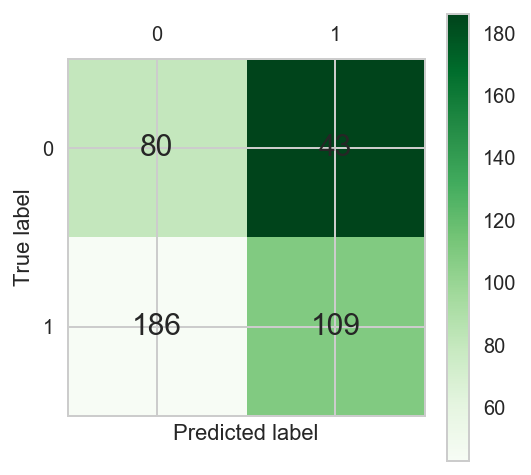

In [134]:
# cm_plot(y_train, model_LR.predict(x_train))
cm_plot(y_test, pred_LR)